### This notebook is meant to be run in Colab. It clones data and code from the GitHub repo.

In [ ]:
# Installs packages and clones GitHub repo to Colab
!pip install import-ipynb # to import functions from other ipynb files
!git clone https://github.com/peepkolberg/CNS-EOG-classifier.git
%cd CNS-EOG-classifier/

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-py3-none-any.whl size=2975 sha256=e623ee20adbcff2408965af77f6c7e718d3bb70fb07ea4a0f66eca2406fc1bdd
  Stored in directory: /root/.cache/pip/wheels/b1/5e/dc/79780689896a056199b0b9f24471e3ee184fbd816df355d5f0
Successfully built import-ipynb
Cloning into 'CNS-EOG-classifier'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 92 (delta 24), reused 38 (delta 14), pack-reused 43
Unpacking objects: 100% (92/92), done.
/content/CNS-EOG-classifier


importing Jupyter notebook from preprocess.ipynb
     |████████████████████████████████| 1.1 MB 4.4 MB/s 
Looks good! All experiments contain all classes.
Total 16 datasets from 16 experiments.


Participant 1 experiment 0 data sample:

     time_sec  time_microsec  ...  signal_horizontal_nk  signal_vertical_nk
0  1237450899         488784  ...           2471.462613        -8734.576266
1  1237450899         499103  ...           1317.719686        -8526.747135
2  1237450899         499143  ...           1719.976759        -9484.918004
3  1237450899         519098  ...           2145.233832        -7695.088873
4  1237450899         519137  ...           2701.490905        -6113.259742

[5 rows x 8 columns]

Columns and their data types: 
time_sec                  int32
time_microsec             int32
time_full               float64
signal_horizontal         int32
signal_vertical           int32
class                     int32
signal_horizontal_nk    float64
signal_vertical_nk      float

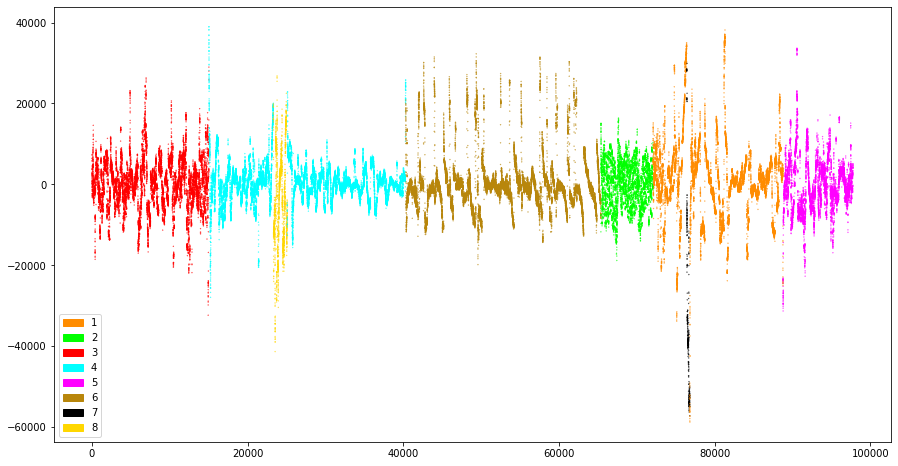

In [ ]:
import import_ipynb
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import preprocess    #import the functions to read .mat files into DataFrames

In [ ]:
# Various data preparing functions. 

def safely_remove_distraction_classes(datasets_dict):
    """
    Removes the distraction classes (labels 7 and 8) from the datasets without concatenating the surrounding class.
    Since each distraction is in the middle of another class, this function separates the surrounding class into two parts.
    The parts will be denoted by appending .1 or .2 to the surrounding class labels that are before and after the distraction class, respectively.
    """
    for participant, experiments in datasets_dict.items():
        for experiment, df in experiments.items():
            for dis_label in (7, 8):
                dis_df_idx = df[df['class'] == dis_label].index
    
                dis_start_idx = dis_df_idx[0]
                dis_end_idx = dis_df_idx[-1]
                #print(f"participant {participant} experiment {experiment} label {dis_label} start index {dis_start_idx} end index {dis_end_idx}")
        
                surrounding_class_label = df['class'][dis_start_idx - 1]
            
                before_dis_class = df[ (df['class'] == surrounding_class_label) & (df.index < dis_start_idx) ]
                after_dis_class = df[ (df['class'] == surrounding_class_label) & (df.index > dis_end_idx) ]
                
                df.loc[before_dis_class.index[0] : dis_start_idx, 'class'] = surrounding_class_label + 0.1
                df.loc[after_dis_class.index[0] : after_dis_class.index[-1]+1, 'class'] = surrounding_class_label + 0.2
                
                df.drop(index=range(dis_start_idx, dis_end_idx+1), inplace=True)
                #print(df['class'].unique())

def data_split(df, data_columns, chunk_size, window_step):
  """
  Input: DataFrame, data column names, chunk size and window step
  Outputs: NumPy arrays of data (X) and labels (y)

  Splits time-series data into equal-sized chunks.
  Also removes the .1 and .2 from previously separated labels.
  """

  X = []
  y = []

  for label in df['class'].unique():
    class_df = df[df['class'] == label]

    signals = np.asarray(class_df[data_columns])
    
    for i in range(0, len(signals), window_step): 
      chunk = signals[i : i + chunk_size]

      if len(chunk) != chunk_size:
        break

      X.append(chunk)
      y.append(int(label))

  return np.asarray(X), np.asarray(y) - 1    # Subtracting 1 from labels because keras tools expect numerical labels to start from 0

def split_datasets(datasets_dict, data_columns, chunk_size, sliding_window_step = -1):
  """ 
  Splits each dataset into chunks. If sliding_window_step argument is given, applies sliding window sampling.
  Also separates signal data (X) and labels (y).
  """

  # If step is not given, move the window by the entire length of the window.
  if sliding_window_step == -1:
    sliding_window_step = chunk_size

  for participant, exps in datasets_dict.items():
    for experiment, data in exps.items():
      #print(f"starting participant {participant} experiment {experiment}")
      X, y = data_split(data, data_columns, chunk_size, sliding_window_step)
      #print(f"got total {len(X)} chunks, {len(y)} labels")
      datasets_dict[participant][experiment] = {'X': X, 'y': y} # <-- To also rename labels to their corresponding words, use rename_labels(y) instead of y

def one_hot_encode_labels(datasets_dict):
  for p, exps in datasets_dict.items():
    for e, data in exps.items():
      data['y'] = to_categorical(data['y'])

def normalize_per_dataset(datasets_dict, data_columns):
  for p, exps in datasets_dict.items():
    for e, data in exps.items():
      for col_name in data_columns:
        initial = np.asarray(data[col_name])
        max, min = np.max(initial), np.min(initial)
        normalized = 2 * ( (initial-min) / (max-min) ) - 1 # normalize between -1 and 1
        data[col_name] = normalized

def print_data_dimensions(datasets_dict):
  total_chunks = 0
  total_labels = 0
  for participant, experiments in datasets_dict.items():
    for experiment, data in experiments.items():
      print(f"participant:{participant}   experiment:{experiment}")
      print(f"signals shape:{data['X'].shape}")
      print(f" labels shape:{data['y'].shape}")
      total_chunks += data['X'].shape[0]
      total_labels += data['y'].shape[0]
  print(f"\nTotal {total_chunks} chunks and {total_labels} labels.   <-- Check that they are equal!")

def concat_datasets(datasets_dict, participants):
  """ Input: datasets dictionary (that has split data and labels for each experiment) """
  X = []
  y = []

  for p in participants:
    for e in datasets_dict[p]:
      X.append(datasets_dict[p][e]['X'])
      y.append(datasets_dict[p][e]['y'])

  X = np.concatenate(X)
  y = np.concatenate(y)
  
  return X, y

def labels_to_words(numerical_labels):
    """ 
    For converting labels from numbers (0-7) to their word representations ('null', 'read', etc.)
    Input: numerical labels as a 1D array. 
    """
    replacements = {0: 'null', 
                    1: 'read', 
                    2: 'browse', 
                    3: 'write', 
                    4: 'video', 
                    5: 'copy', 
                    6: 'disspeak', 
                    7: 'disphone'}
    return np.asarray([replacements[old_label] for old_label in numerical_labels])

def plot_conf_matrix(true_labels, predictions):
  fig = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(true_labels, predictions)).plot(cmap=plt.cm.Blues)
  plt.title(f"Participant {testing_participant} confusion matrix")
  ax = plt.gca()
  plt.xticks([0,1,2,3,4,5], ['null','read','browse','write','video','copy'])
  plt.yticks([0,1,2,3,4,5], ['null','read','browse','write','video','copy'])
  ax.xaxis.set_ticks_position('top')
  ax.xaxis.set_label_position('top')
  plt.show()



# UNUSED FUNCTIONS
def get_global_max_and_min(datasets_dict, col_name):
  datas = []

  # concat all columns of that name
  for p, exps in datasets_dict.items():
    for e, data in exps.items():
      datas.append(data[col_name])

  datas = np.asarray(datas)
  data = np.concatenate(datas)

  return np.max(data), np.min(data)

def get_delta(column_data):
  initial = np.append(column_data, 0)
  helper = np.concatenate(([column_data[0]], column_data))
  delta = initial - helper
  delta = np.absolute(delta)
  return delta[:-1]

def add_signal_deltas(datasets_dict):
  for p, exps in datasets_dict.items():
    for e, data in exps.items():
      data['signal_horizontal_delta'] = get_delta(data['signal_horizontal'])
      data['signal_vertical_delta'] = get_delta(data['signal_vertical'])


In [ ]:
# Read files into dataframes (see function description in preprocess.ipynb for details)
datasets_dict = preprocess.read_all_files()

# Remove distraction classes
# The classes that surround the distraction class will be split into two parts by appending .1 or .2 to the label. 
safely_remove_distraction_classes(datasets_dict)

# Add columns for signal deltas - broken
#add_signal_deltas(datasets_dict)

# Define which columns contain the desired signal datas
data_columns = [
                #'signal_horizontal', 
                #'signal_vertical', 
                'signal_horizontal_nk', 
                'signal_vertical_nk'
                ]

# Normalize each feature in each dataset
normalize_per_dataset(datasets_dict, data_columns)

# Split each class in dataset into chunks. Can be used for sliding window sampling (sliding_window_step argument must be given).
#
# Also subtracts 1 from all labels so they start from 0.
split_datasets(datasets_dict, data_columns, chunk_size = 3640, sliding_window_step = 128)

# One-hot encode labels
one_hot_encode_labels(datasets_dict)

# Print the final dimensions of each dataset
print_data_dimensions(datasets_dict)

participant:1   experiment:0
signals shape:(523, 3640, 2)
 labels shape:(523, 6)
participant:1   experiment:1
signals shape:(980, 3640, 2)
 labels shape:(980, 6)
participant:2   experiment:0
signals shape:(1472, 3640, 2)
 labels shape:(1472, 6)
participant:2   experiment:1
signals shape:(660, 3640, 2)
 labels shape:(660, 6)
participant:3   experiment:0
signals shape:(1442, 3640, 2)
 labels shape:(1442, 6)
participant:3   experiment:1
signals shape:(1495, 3640, 2)
 labels shape:(1495, 6)
participant:4   experiment:0
signals shape:(1298, 3640, 2)
 labels shape:(1298, 6)
participant:4   experiment:1
signals shape:(1271, 3640, 2)
 labels shape:(1271, 6)
participant:5   experiment:0
signals shape:(1370, 3640, 2)
 labels shape:(1370, 6)
participant:5   experiment:1
signals shape:(1143, 3640, 2)
 labels shape:(1143, 6)
participant:6   experiment:0
signals shape:(1398, 3640, 2)
 labels shape:(1398, 6)
participant:6   experiment:1
signals shape:(1217, 3640, 2)
 labels shape:(1217, 6)
participan


Starting testing participant 1

Training data shape: (17561, 3640, 2)   labels shape: (17561, 6)
Testing data shape:  (1503, 3640, 2)    labels shape: (1503, 6)

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_152 (Conv1D)         (None, 3530, 4)           892       
                                                                 
 max_pooling1d_148 (MaxPooli  (None, 1765, 4)          0         
 ng1D)                                                           
                                                                 
 conv1d_153 (Conv1D)         (None, 1635, 8)           4200      
                                                                 
 max_pooling1d_149 (MaxPooli  (None, 817, 8)           0         
 ng1D)                                                           
                                                                 
 conv1d_154 (Conv1D)  

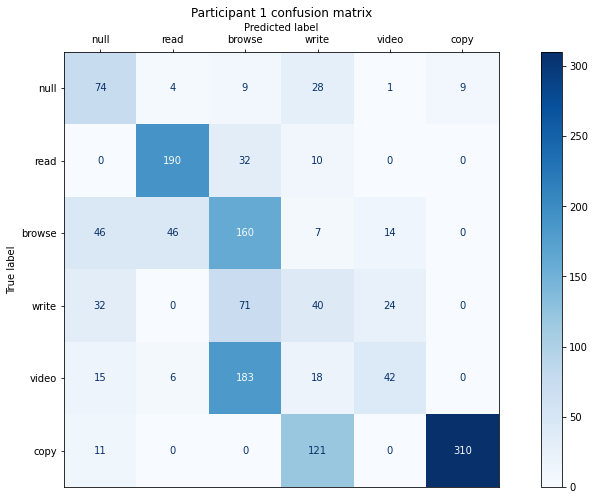


Starting testing participant 2

Training data shape: (16932, 3640, 2)   labels shape: (16932, 6)
Testing data shape:  (2132, 3640, 2)    labels shape: (2132, 6)

Epoch 1/20
424/424 [==============================] - 13s 29ms/step - loss: 2.1908 - accuracy: 0.3389 - val_loss: 1.5812 - val_accuracy: 0.3452
Epoch 2/20
424/424 [==============================] - 12s 28ms/step - loss: 1.2176 - accuracy: 0.5653 - val_loss: 3.0338 - val_accuracy: 0.4010
Epoch 3/20
424/424 [==============================] - 12s 29ms/step - loss: 0.9534 - accuracy: 0.7039 - val_loss: 1.2028 - val_accuracy: 0.6168
Epoch 4/20
424/424 [==============================] - 12s 28ms/step - loss: 0.8454 - accuracy: 0.7498 - val_loss: 1.4117 - val_accuracy: 0.5671
Epoch 5/20
424/424 [==============================] - 12s 28ms/step - loss: 0.7681 - accuracy: 0.7882 - val_loss: 1.1750 - val_accuracy: 0.6515
Epoch 6/20
424/424 [==============================] - 12s 28ms/step - loss: 0.7520 - accuracy: 0.8038 - val_loss: 1.2

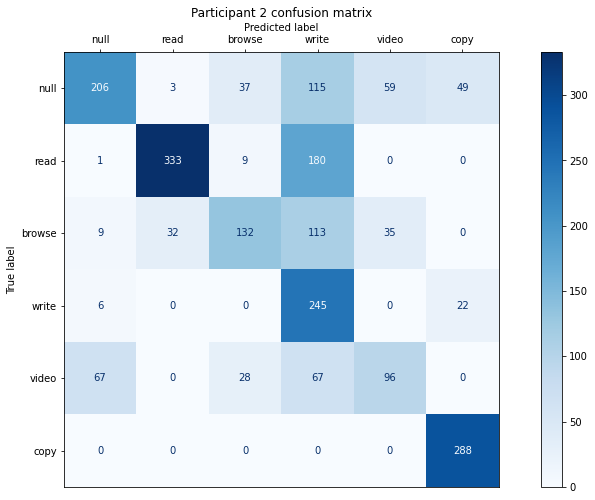


Starting testing participant 3

Training data shape: (16127, 3640, 2)   labels shape: (16127, 6)
Testing data shape:  (2937, 3640, 2)    labels shape: (2937, 6)

Epoch 1/20
404/404 [==============================] - 13s 29ms/step - loss: 2.2806 - accuracy: 0.3028 - val_loss: 1.4749 - val_accuracy: 0.4545
Epoch 2/20
404/404 [==============================] - 11s 28ms/step - loss: 1.4062 - accuracy: 0.4367 - val_loss: 1.4865 - val_accuracy: 0.4590
Epoch 3/20
404/404 [==============================] - 12s 29ms/step - loss: 1.2345 - accuracy: 0.5248 - val_loss: 1.2591 - val_accuracy: 0.5373
Epoch 4/20
404/404 [==============================] - 12s 29ms/step - loss: 1.1478 - accuracy: 0.5751 - val_loss: 1.2421 - val_accuracy: 0.6261
Epoch 5/20
404/404 [==============================] - 12s 29ms/step - loss: 1.1091 - accuracy: 0.6005 - val_loss: 1.1214 - val_accuracy: 0.6316
Epoch 6/20
404/404 [==============================] - 12s 29ms/step - loss: 1.0476 - accuracy: 0.6298 - val_loss: 1.1

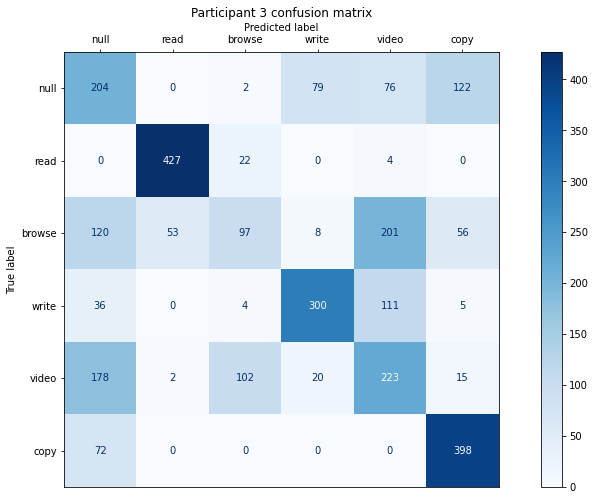


Starting testing participant 4

Training data shape: (16495, 3640, 2)   labels shape: (16495, 6)
Testing data shape:  (2569, 3640, 2)    labels shape: (2569, 6)

Epoch 1/20
413/413 [==============================] - 13s 29ms/step - loss: 2.6927 - accuracy: 0.1808 - val_loss: 1.8296 - val_accuracy: 0.2102
Epoch 2/20
413/413 [==============================] - 12s 28ms/step - loss: 1.8121 - accuracy: 0.1798 - val_loss: 1.8103 - val_accuracy: 0.1226
Epoch 3/20
413/413 [==============================] - 12s 28ms/step - loss: 1.7984 - accuracy: 0.1811 - val_loss: 1.7970 - val_accuracy: 0.1584
Epoch 4/20
413/413 [==============================] - 12s 29ms/step - loss: 1.7943 - accuracy: 0.1786 - val_loss: 1.7958 - val_accuracy: 0.1226
Epoch 5/20
413/413 [==============================] - 12s 29ms/step - loss: 1.7927 - accuracy: 0.1787 - val_loss: 1.7955 - val_accuracy: 0.1226
Epoch 6/20
413/413 [==============================] - 12s 29ms/step - loss: 1.7932 - accuracy: 0.1796 - val_loss: 1.8

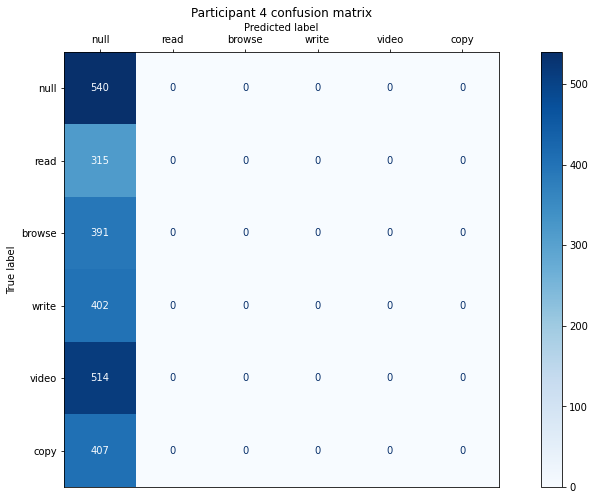


Starting testing participant 5

Training data shape: (16551, 3640, 2)   labels shape: (16551, 6)
Testing data shape:  (2513, 3640, 2)    labels shape: (2513, 6)

Epoch 1/20
414/414 [==============================] - 13s 30ms/step - loss: 2.1548 - accuracy: 0.3943 - val_loss: 1.3958 - val_accuracy: 0.4453
Epoch 2/20
414/414 [==============================] - 12s 29ms/step - loss: 1.1088 - accuracy: 0.6303 - val_loss: 1.3810 - val_accuracy: 0.5464
Epoch 3/20
414/414 [==============================] - 12s 29ms/step - loss: 0.9453 - accuracy: 0.7054 - val_loss: 1.5399 - val_accuracy: 0.5189
Epoch 4/20
414/414 [==============================] - 12s 29ms/step - loss: 0.8179 - accuracy: 0.7684 - val_loss: 1.4584 - val_accuracy: 0.5511
Epoch 5/20
414/414 [==============================] - 12s 29ms/step - loss: 0.7283 - accuracy: 0.8048 - val_loss: 1.3297 - val_accuracy: 0.6522
Epoch 6/20
414/414 [==============================] - 12s 29ms/step - loss: 0.7106 - accuracy: 0.8197 - val_loss: 1.6

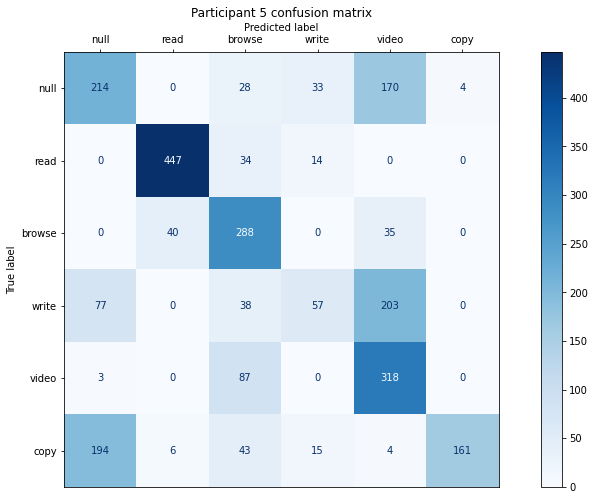


Starting testing participant 6

Training data shape: (16449, 3640, 2)   labels shape: (16449, 6)
Testing data shape:  (2615, 3640, 2)    labels shape: (2615, 6)

Epoch 1/20
412/412 [==============================] - 14s 30ms/step - loss: 2.3692 - accuracy: 0.3280 - val_loss: 1.5972 - val_accuracy: 0.3369
Epoch 2/20
412/412 [==============================] - 12s 29ms/step - loss: 1.3499 - accuracy: 0.4891 - val_loss: 1.1880 - val_accuracy: 0.5163
Epoch 3/20
412/412 [==============================] - 12s 29ms/step - loss: 1.1261 - accuracy: 0.6037 - val_loss: 0.9573 - val_accuracy: 0.6979
Epoch 4/20
412/412 [==============================] - 12s 29ms/step - loss: 0.9643 - accuracy: 0.6926 - val_loss: 0.8262 - val_accuracy: 0.7740
Epoch 5/20
412/412 [==============================] - 12s 29ms/step - loss: 0.8586 - accuracy: 0.7321 - val_loss: 0.9436 - val_accuracy: 0.7063
Epoch 6/20
412/412 [==============================] - 12s 29ms/step - loss: 0.8016 - accuracy: 0.7569 - val_loss: 0.9

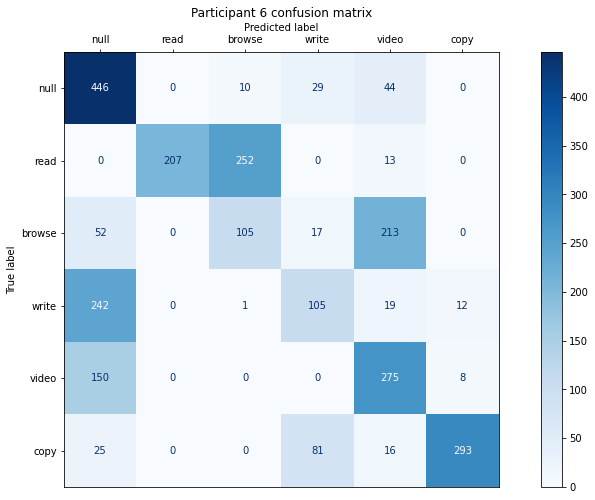


Starting testing participant 7

Training data shape: (16798, 3640, 2)   labels shape: (16798, 6)
Testing data shape:  (2266, 3640, 2)    labels shape: (2266, 6)

Epoch 1/20
420/420 [==============================] - 14s 30ms/step - loss: 2.2121 - accuracy: 0.3339 - val_loss: 1.4520 - val_accuracy: 0.3866
Epoch 2/20
420/420 [==============================] - 12s 29ms/step - loss: 1.2729 - accuracy: 0.5314 - val_loss: 1.4488 - val_accuracy: 0.5040
Epoch 3/20
420/420 [==============================] - 12s 29ms/step - loss: 1.0723 - accuracy: 0.6028 - val_loss: 1.7591 - val_accuracy: 0.5119
Epoch 4/20
420/420 [==============================] - 12s 29ms/step - loss: 1.0114 - accuracy: 0.6326 - val_loss: 1.5907 - val_accuracy: 0.5874
Epoch 5/20
420/420 [==============================] - 12s 29ms/step - loss: 0.9714 - accuracy: 0.6622 - val_loss: 1.3659 - val_accuracy: 0.5790
Epoch 6/20
420/420 [==============================] - 12s 29ms/step - loss: 0.9061 - accuracy: 0.6955 - val_loss: 1.3

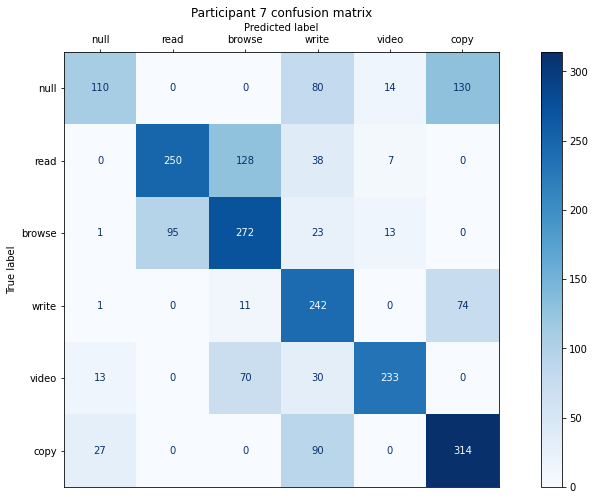


Starting testing participant 8

Training data shape: (16535, 3640, 2)   labels shape: (16535, 6)
Testing data shape:  (2529, 3640, 2)    labels shape: (2529, 6)

Epoch 1/20
414/414 [==============================] - 14s 31ms/step - loss: 2.1539 - accuracy: 0.3707 - val_loss: 1.7576 - val_accuracy: 0.3646
Epoch 2/20
414/414 [==============================] - 12s 29ms/step - loss: 1.2524 - accuracy: 0.5019 - val_loss: 1.8435 - val_accuracy: 0.4235
Epoch 3/20
414/414 [==============================] - 12s 29ms/step - loss: 1.1380 - accuracy: 0.5658 - val_loss: 2.1480 - val_accuracy: 0.4124
Epoch 4/20
414/414 [==============================] - 12s 29ms/step - loss: 1.0571 - accuracy: 0.6054 - val_loss: 2.8411 - val_accuracy: 0.4326
Epoch 5/20
414/414 [==============================] - 12s 29ms/step - loss: 0.9626 - accuracy: 0.6609 - val_loss: 4.2945 - val_accuracy: 0.3733
Epoch 6/20
414/414 [==============================] - 12s 30ms/step - loss: 0.9176 - accuracy: 0.6850 - val_loss: 4.0

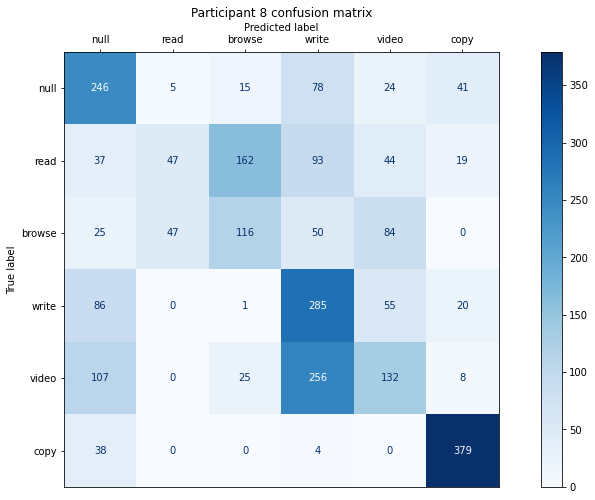

In [ ]:
# Testing the CNN

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import PredefinedSplit

from keras.models import Sequential
from keras.layers import Conv1D, Dense, Dropout, Input, LayerNormalization, BatchNormalization, AveragePooling1D, MaxPooling1D, Flatten
from keras.regularizers import l2


def grid_search(X_train, y_train, X_test, y_test):
  model = KerasClassifier(build_fn=compile_model, verbose=0)

  batch_size = [10, 20, 30, 40, 60, 80, 100]
  epochs = [10, 20, 30, 50, 70, 100]
  optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
  cnn_activation = ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
  dense_activation = ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
  dropout_rate = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]

  param_grid = dict(batch_size=batch_size,
                    epochs=epochs, 
                    optimizer=optimizer, 
                    cnn_activation=cnn_activation, 
                    dense_activation=dense_activation, 
                    dropout_rate=dropout_rate
                    )
  
  X = np.concatenate([X_train, X_test])
  y = np.concatenate([y_train, y_test])
  test_fold = np.concatenate([np.repeat(-1, len(y_train)), np.repeat(0, len(y_test))])
  
  grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=PredefinedSplit(test_fold=test_fold))
  grid_result = grid.fit(X, y)

  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
  means = grid_result.cv_results_['mean_test_score']
  stds = grid_result.cv_results_['std_test_score']
  params = grid_result.cv_results_['params']
  for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

def compile_model(input_shape = (625, 4), output_nodes = 6, optimizer = 'adam', cnn_activation = 'relu', dense_activation = 'relu', dropout_rate = 0.2):
  model = Sequential()

  # TODO:
  # test way more and larger filters (also in descending order) - no effect (train over 95, val 45)
  # add padding = 'same' to conv layers - close to no effect (train over 95, val 40)
  # Add batchnorms - worse (train over 95, val 30)
  # kernel sizes to 100s (increasing in size), also chunk size to 3640 - slightly better (train over 95, val 50) 
  # weight decay of 0.1 to conv and dense layers - way worse (train 18, val 10)
  # weight decay of 0.05 to conv and dense layers - kinda worse (train 63, val 45)
  # weight decay of 0.001 to conv and dense layers - better (train over 95 and grows fast, val 54)
  # weight decay of 0.01 to conv and dense layers -  best, some weird behaviour appears tho (train over 90 but grows slower, val 55)

  # use Conv1DLSTM layers instead of regular conv
  # try training with only consistently measured data
    # if previous point raises acc, interpolate poorly measured data
  # for feature extraction: calculate distance from midpoint
  # normalize data to have mean 0 and std 1.

  model.add(Input(shape = input_shape))

  model.add(Conv1D(4, 111, activation=cnn_activation, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
  model.add(MaxPooling1D(2))

  model.add(Conv1D(8, 131, activation=cnn_activation, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
  model.add(MaxPooling1D(2))

  model.add(Conv1D(16, 151, activation=cnn_activation, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
  model.add(MaxPooling1D(2))

  model.add(Conv1D(32, 171, activation=cnn_activation, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
  model.add(MaxPooling1D(2))

  model.add(Flatten())

  # Automatically find the nr of nodes that the Flatten layer has.
  # The following Dense layer will have the same nr of nodes.
  # Would be great if someone got it to work.
  #print(model.get_layer(index=-1))

  model.add(Dense(2592, activation=dense_activation, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
  model.add(Dropout(dropout_rate))
  #model.add(Dense(896, activation=dense_activation))
  #model.add(Dropout(dropout_rate))
  #model.add(Dense(224, activation=dense_activation))
  #model.add(Dropout(dropout_rate))
  #model.add(Dense(56, activation=dense_activation))
  #model.add(Dropout(dropout_rate))
  #model.add(Dense(36, activation=dense_activation))
  #model.add(Dropout(dropout_rate))
  #model.add(Dense(16, activation=dense_activation))
  #model.add(Dropout(dropout_rate))

  model.add(Dense(output_nodes, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model



# For each test, one participant is the test participant (not included in the training set).

results = {}    # Save the histories of each testing participant
first_iteration = True    # For printing the model summary only once

for testing_participant in range(1, 9):
  training_participants = list(range(1, 9))
  training_participants.remove(testing_participant)
  
  X_train, y_train = concat_datasets(datasets_dict, training_participants)
  X_test, y_test = concat_datasets(datasets_dict, [testing_participant])

  X_train, y_train = shuffle(X_train, y_train)
  X_test, y_test = shuffle(X_test, y_test)

  print(f"Training data shape: {X_train.shape}   labels shape: {y_train.shape}")
  print(f"Testing data shape:  {X_test.shape}    labels shape: {y_test.shape}\n")

  # Makes a fresh model for every person
  model = compile_model(input_shape = X_train.shape[1:], output_nodes = y_train.shape[1])

  if first_iteration:
    model.summary()
    first_iteration = False

  print(f"\nStarting testing participant {testing_participant}\n")
  
  #break

  # Run Grid Search or fit the model (uncomment one line or the other)
  #grid_search(X_train, y_train, X_test, y_test)
  results[testing_participant] = model.fit(X_train, y_train, batch_size = 40, epochs=20, validation_data = (X_test, y_test)) # saves the history of the training session

  # Plot the confusion matrix (comment this segment out if running Grid Search)
  true_labels = [np.argmax(el) for el in y_test]
  predictions = [np.argmax(el) for el in model.predict(X_test)]
  plot_conf_matrix(true_labels, predictions)
  #break

There is some weird behaviour. 

Firstly, there is always one participant with an accuracy that is the same as random (around 15%). For that participant the model always predicts only one class. 

Secondly, that participant with poor accuracy is different in each execution. Also, the constantly predicted class differs.

Thirdly, in different executions, different participants have above average accuracies.